In [8]:
import PIL

PIL.PILLOW_VERSION='7.0.0'

import PIL.Image as Image
import torch
from torch import nn , optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import train
import time
#from PIL import Image
#import PIL.Image as Image
from torch.autograd import Variable
import random,os
import matplotlib.pyplot as plt
import numpy as np

In [9]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [10]:

data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                               transforms.RandomResizedCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
                                               ]),
                  'valid': transforms.Compose([transforms.Resize(256),
                                               transforms.RandomResizedCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
                                               ]),
                  'test': transforms.Compose([transforms.Resize(256),
                                               transforms.RandomResizedCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
                                               ])}


train_image_datasets = datasets.ImageFolder(train_dir,transform=data_transforms['train'] )
valid_image_datasets = datasets.ImageFolder(valid_dir,transform=data_transforms['valid'] )
test_image_datasets = datasets.ImageFolder(test_dir,transform=data_transforms['test'] )


train_dataloaders = torch.utils.data.DataLoader(train_image_datasets,batch_size=64,shuffle=True)
valid_dataloaders = torch.utils.data.DataLoader(valid_image_datasets,batch_size=64,shuffle=True)
test_dataloaders = torch.utils.data.DataLoader(test_image_datasets,batch_size=64,shuffle=True)

In [11]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [12]:
model=models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/vishalduhan/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
for param in model.parameters():
    param.required_grad=False

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cpu')

In [15]:
"""""features = list(model.classifier.children())[:-1]
num_filters = model.classifier[len(features)].in_features
print(num_filters)
features.extend([
        nn.Dropout(),
        nn.Linear(num_filters, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Linear(4096, 102),
        
    ])
    
model.classifier = nn.Sequential(*features)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-15-aa7873ce9a5e>, line 15)

In [16]:
classifier = nn.Sequential(
                           nn.Linear(25088, 1024),
                           nn.Dropout(p=0.3),
                           nn.ReLU(),
                           nn.Linear(1024, 102),
                           nn.LogSoftmax(dim=1))
model.classifier=classifier

In [20]:

"""model.classifier = nn.Sequential(
                           nn.Linear(25088, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.Dropout(p=0.3),
                           nn.ReLU(),
                           nn.Linear(512, 102),
                           nn.LogSoftmax(dim=1))"""


criterion = nn.NLLLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
model.to(device)
epochs = 6
train_losses, valid_losses = [], []

for e in range(epochs):
    start=time.time()
    running_loss = 0
    model.train()
    for images, labels in train_dataloaders:
        # Flatten MNIST images into a 784 long vector
        
        images, labels = images.to(device), labels.to(device)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        
        valid_loss = 0
        accuracy = 0
        
        
        with torch.no_grad():
            model.eval()
            for images, labels in valid_dataloaders:
                images, labels = images.to(device), labels.to(device)
                output = model.forward(images)
                valid_loss += criterion(output, labels)
                
                ps = torch.exp(output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
                
        train_losses.append(running_loss/len(train_dataloaders))
        valid_losses.append(valid_loss/len(valid_dataloaders))
        end=time.time()
        totaltime=end-start
        print("time for {} epoch is {}".format(e+1,totaltime))
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_dataloaders)),
              "Valid Loss: {:.3f}.. ".format(valid_loss/len(valid_dataloaders)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(valid_dataloaders)))

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='flowers/train/11/image_03157.jpg'>

In [9]:
test_loss=0
accuracy=0
test_losses=[]
for e in range(4):
    test_loss=0
    accuracy=0
    with torch.no_grad():
        model.eval()
        for images,labels in test_dataloaders:
            images,labels= images.to(device), labels.to(device)
        
            output=model.forward(images)
            test_loss += criterion(output,labels)
            prob=torch.exp(output)
            top_p, top_class = prob.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            test_losses.append(test_loss/len(test_dataloaders))
        print("Test Loss: {:.3f}.. ".format(test_loss/len(test_dataloaders)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloaders)))


Test Loss: 1.047..  Test Accuracy: 0.776
Test Loss: 1.061..  Test Accuracy: 0.757
Test Loss: 1.090..  Test Accuracy: 0.759
Test Loss: 1.080..  Test Accuracy: 0.757


In [8]:
model.class_to_idx=train_image_datasets.class_to_idx
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'arch': 'vgg16',
              'learning_rate': 0.01,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

NameError: name 'classifier' is not defined

In [9]:
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    learning_rate = checkpoint['learning_rate']
    model = getattr(models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer'])
        
    return model, optimizer

filename = 'checkpoint.pth'
model, optimizer = load_checkpoint(filename)

C:\Users\vishal-mypc\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\vishal-mypc\Anaconda3\lib\site-packages\torch\serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

In [13]:
def process_image(image):
    
    im = Image.open(image)
    im = im.resize((256,256))
    center = 0.5*(256-224)
    im = im.crop((center,center,256-center,256-center))
    im = np.array(im)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = (im - mean) / std

    return im.transpose(2,0,1)

In [14]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

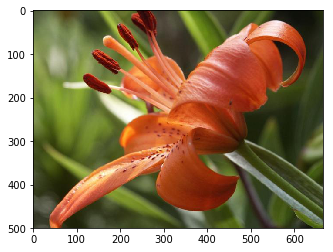

In [44]:
img = random.choice(os.listdir('./flowers/test/6/'))
img_path = './flowers/test/6/' + img

with Image.open(img_path) as image:
    plt.imshow(image)

In [45]:
def predict(image_path, model, topk=5):
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    device
    # TODO: Implement the code to predict the class from an image file
    model.eval()

    # The image
    image = process_image(image_path)
    
    # tranfer to tensor
    image = torch.from_numpy(np.array([image])).float()
    
    # The image becomes the input
    image = Variable(image)
    
    image=image.to(device)    
    output = model.forward(image)
    
    probabilities = torch.exp(output).data
    
    # getting the topk (=5) probabilites and indexes
    # 0 -> probabilities
    # 1 -> index
    prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
    index = torch.topk(probabilities, topk)[1].tolist()[0] # index
    
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    # transfer index to label
    label = []
    for i in range(5):
        label.append(ind[index[i]])

    return prob, label

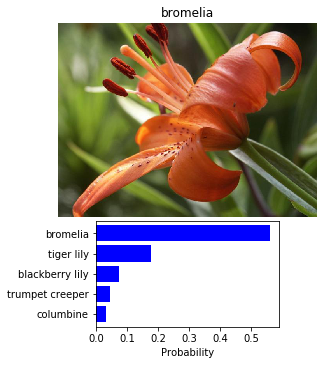

In [46]:
prob, classes = predict(img_path, model)
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(img_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)

labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

plt.show()